In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

keras = tf.keras
print(tf.__version__)

2.0.0-alpha0


In [0]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

TensorShape([500, 343, 3])

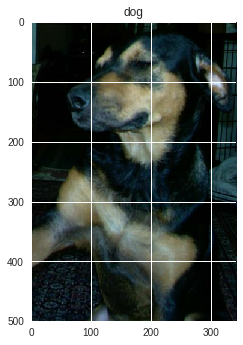

In [31]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))
  
image.shape

In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1 # normalization to bring values to range [-1.0,1.0]
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [57]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

type(raw_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Let's take a look at the base model architecture
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
(32, 1280)
(32, 1)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                    

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [16]:
initial_epochs = 5
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

# evaluate inital loss/accuracy without training
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 118ms/step - loss: 6.0556 - accuracy: 0.5219
initial loss: 6.06
initial accuracy: 0.52


In [17]:
# training
history = model.fit(train_batches.repeat(),
                    epochs=initial_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=validation_batches.repeat(), 
                    validation_steps=validation_steps)

Epoch 1/10
581/581 [==============================] - 102s 175ms/step - loss: 2.8695 - accuracy: 0.6661 - val_loss: 0.8823 - val_accuracy: 0.8641
Epoch 2/10
581/581 [==============================] - 97s 167ms/step - loss: 1.0752 - accuracy: 0.8534 - val_loss: 0.5128 - val_accuracy: 0.9234
Epoch 3/10
581/581 [==============================] - 97s 167ms/step - loss: 0.7892 - accuracy: 0.8936 - val_loss: 0.4184 - val_accuracy: 0.9375
Epoch 4/10
581/581 [==============================] - 98s 169ms/step - loss: 0.6720 - accuracy: 0.9093 - val_loss: 0.4376 - val_accuracy: 0.9500
Epoch 5/10
581/581 [==============================] - 101s 173ms/step - loss: 0.6014 - accuracy: 0.9204 - val_loss: 0.4120 - val_accuracy: 0.9516
Epoch 6/10
581/581 [==============================] - 98s 168ms/step - loss: 0.5388 - accuracy: 0.9284 - val_loss: 0.3900 - val_accuracy: 0.9609
Epoch 7/10
581/581 [==============================] - 97s 166ms/step - loss: 0.4934 - accuracy: 0.9320 - val_loss: 0.3805 - val_

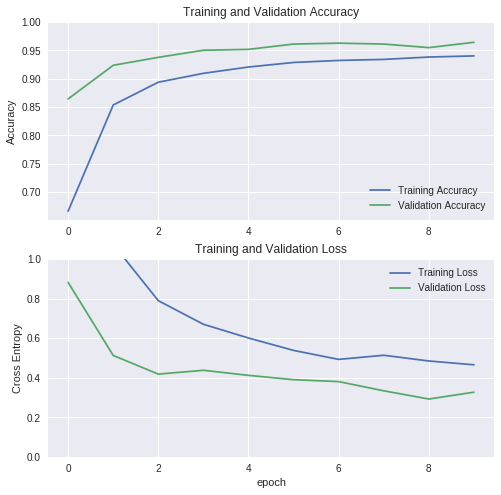

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()